# Stent Placement Risk Prediction

## Goal
The goal of this project is to predict whether a patient will have an adverse outcome after coronary stent placement.

- **True label (what actually happened):**
  - `0 = no event`
  - `1 = event`

## Models I used
1. **Random Forest**
2. **Feedforward Neural Network (MLP)**

## Why imbalance matters
Bad outcomes are usually rare, so there are many more `0`s than `1`s.  
To handle this imbalance:

- **Random Forest:** use **SMOTE** (creates synthetic minority examples)
- **Neural Network:** use **class-weighted loss** (makes mistakes on the rare class “cost more”)

## How I evaluate
- **ROC-AUC**
- **PR-AUC (Precision–Recall AUC)** → better when positives are rare

## Risk categories (Low / Medium / High)
Even though the model learns `0/1`, it outputs a **probability**.  
I convert the probability into 3 risk groups using percentiles:

- **Low:** bottom 70% of predicted probabilities  
- **Medium:** next 20% (70th–90th percentile)  
- **High:** top 10% (≥ 90th percentile)


In [1]:
!pip -q install pandas numpy scikit-learn imbalanced-learn matplotlib torch shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


## 1) Create Synthetic Clinical Data (since I don’t have real patient data)

I don’t have access to real hospital data, so I generate synthetic data that looks like clinical data:
- demographics (age, sex)
- comorbidities (CKD, diabetes, etc.)
- labs (creatinine, hemoglobin)
- procedure features (stent type, access site)

Then I create an outcome using a risk score so events are rare-ish and more likely for high-risk patients.


In [2]:
def make_synthetic_stent_data(n=6000, seed=42):
    rng = np.random.default_rng(seed)

    # Demographics & comorbidities
    age = rng.integers(35, 90, size=n)
    sex = rng.choice(["M", "F"], size=n, p=[0.65, 0.35])
    diabetes = rng.binomial(1, 0.30, size=n)
    ckd = rng.binomial(1, 0.12, size=n)
    smoker = rng.binomial(1, 0.25, size=n)
    prior_mi = rng.binomial(1, 0.18, size=n)
    htn = rng.binomial(1, 0.55, size=n)

    # Labs / vitals
    creatinine = np.clip(rng.normal(1.1, 0.4, size=n) + 0.6*ckd, 0.4, 6.0)
    hemoglobin = np.clip(rng.normal(13.5, 1.5, size=n) - 1.0*ckd, 7.0, 18.0)
    systolic_bp = np.clip(rng.normal(132, 18, size=n) + 8*htn, 80, 220)

    # Procedure features
    lesion_length = np.clip(rng.normal(22, 10, size=n), 5, 60)
    multivessel = rng.binomial(1, 0.28, size=n)
    calcified = rng.binomial(1, 0.22, size=n)
    stent_type = rng.choice(["DES", "BMS"], size=n, p=[0.88, 0.12])
    access_site = rng.choice(["Radial", "Femoral"], size=n, p=[0.75, 0.25])

    # Risk score (higher score -> higher event probability)
    score = (
        0.03*(age - 60)
        + 0.8*ckd
        + 0.4*diabetes
        + 0.2*prior_mi
        + 0.015*(lesion_length - 20)
        + 0.5*calcified
        + 0.25*multivessel
        + 0.15*(access_site == "Femoral")
        + 0.2*(stent_type == "BMS")
        + 0.3*(creatinine - 1.0)
        - 0.08*(hemoglobin - 13.0)
    )

    # Convert score -> probability, then sample outcome
    p = 1 / (1 + np.exp(-(score - 2.2)))  # shift keeps event rate low
    label = rng.binomial(1, p)

    df = pd.DataFrame({
        "age": age,
        "sex": sex,
        "diabetes": diabetes,
        "ckd": ckd,
        "smoker": smoker,
        "prior_mi": prior_mi,
        "htn": htn,
        "creatinine": creatinine,
        "hemoglobin": hemoglobin,
        "systolic_bp": systolic_bp,
        "lesion_length": lesion_length,
        "multivessel": multivessel,
        "calcified": calcified,
        "stent_type": stent_type,
        "access_site": access_site,
        "label": label
    })
    return df

df = make_synthetic_stent_data()
print("Dataset shape:", df.shape)
print("Event rate:", df["label"].mean())
print(df["label"].value_counts())
df.head()


Dataset shape: (6000, 16)
Event rate: 0.18916666666666668
label
0    4865
1    1135
Name: count, dtype: int64


,age,sex,diabetes,ckd,smoker,prior_mi,htn,creatinine,hemoglobin,systolic_bp,lesion_length,multivessel,calcified,stent_type,access_site,label
0,39,F,1,0,0,0,1,0.614440,13.341287,139.499595,24.750594,1,1,DES,Radial,0
1,77,M,0,0,0,0,1,0.481774,13.656861,110.315280,12.696709,1,0,BMS,Radial,0
2,71,M,0,0,1,0,0,0.803977,15.294574,138.763089,21.724816,0,1,DES,Radial,1
3,59,F,0,0,1,0,1,1.321340,12.930470,140.358324,20.475263,0,1,DES,Radial,0
4,58,M,0,0,0,0,0,0.928764,12.468824,135.838083,28.777813,1,1,BMS,Radial,1


## 2) Train / Validation / Test Split

I split the data into:
- Train: model learns here
- Validation: model selection/analysis here
- Test: final evaluation here

I use stratification so each split has a similar event rate.


In [3]:
X = df.drop(columns=["label"])
y = df["label"].astype(int)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.15/0.85, random_state=42, stratify=y_trainval
)

print("Train:", X_train.shape, "Event rate:", y_train.mean())
print("Val:  ", X_val.shape, "Event rate:", y_val.mean())
print("Test: ", X_test.shape, "Event rate:", y_test.mean())


Train: (4199, 15) Event rate: 0.1893307930459633
Val:   (901, 15) Event rate: 0.18867924528301888
Test:  (900, 15) Event rate: 0.18888888888888888


## 3) Preprocessing

Models need clean numeric input:
- Numeric: fill missing values with median + scale
- Categorical: fill missing values + one-hot encode


In [4]:
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['age', 'diabetes', 'ckd', 'smoker', 'prior_mi', 'htn', 'creatinine', 'hemoglobin', 'systolic_bp', 'lesion_length', 'multivessel', 'calcified']
Categorical columns: ['sex', 'stent_type', 'access_site']


## 4) Random Forest + SMOTE

Random Forest is a strong baseline model.
SMOTE helps by creating extra synthetic positive examples during training.


RF ROC-AUC: 0.629363482739197
RF PR-AUC:  0.3011387207243703


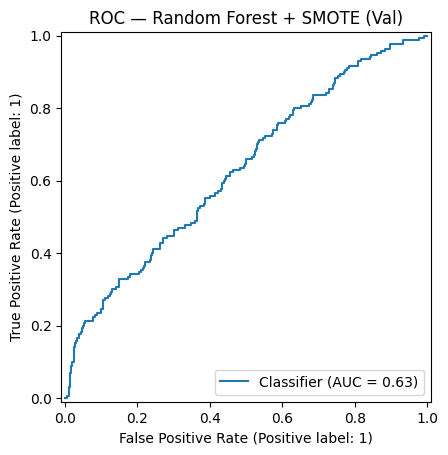

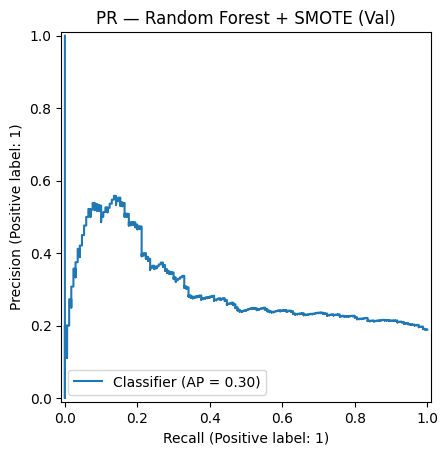

In [5]:
rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("rf", rf)
])

rf_model.fit(X_train, y_train)

rf_val_proba = rf_model.predict_proba(X_val)[:, 1]
print("RF ROC-AUC:", roc_auc_score(y_val, rf_val_proba))
print("RF PR-AUC: ", average_precision_score(y_val, rf_val_proba))

RocCurveDisplay.from_predictions(y_val, rf_val_proba)
plt.title("ROC — Random Forest + SMOTE (Val)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_val, rf_val_proba)
plt.title("PR — Random Forest + SMOTE (Val)")
plt.show()


## 5) Feedforward Neural Network (MLP)

An MLP is a feedforward neural network (fully-connected layers).
Instead of SMOTE, I use class-weighted loss to focus more on the rare positive class.


In [6]:
# Convert train/val/test into numeric matrices
X_train_t = preprocessor.fit_transform(X_train)
X_val_t   = preprocessor.transform(X_val)
X_test_t  = preprocessor.transform(X_test)

def to_dense(x):
    return x.toarray() if hasattr(x, "toarray") else x

X_train_np = to_dense(X_train_t).astype(np.float32)
X_val_np   = to_dense(X_val_t).astype(np.float32)
X_test_np  = to_dense(X_test_t).astype(np.float32)

y_train_np = y_train.values.astype(np.float32)
y_val_np   = y_val.values.astype(np.float32)
y_test_np  = y_test.values.astype(np.float32)

X_train_np.shape


(4199, 18)

Epoch 01 | loss=1.0900 | Val PR=0.3291 | Val ROC=0.6832
Epoch 02 | loss=1.0410 | Val PR=0.3363 | Val ROC=0.6852
Epoch 03 | loss=1.0266 | Val PR=0.3313 | Val ROC=0.6813
Epoch 04 | loss=1.0184 | Val PR=0.3294 | Val ROC=0.6791
Epoch 05 | loss=1.0165 | Val PR=0.3329 | Val ROC=0.6799
Epoch 06 | loss=1.0192 | Val PR=0.3295 | Val ROC=0.6789
Epoch 07 | loss=1.0072 | Val PR=0.3274 | Val ROC=0.6768
Epoch 08 | loss=1.0174 | Val PR=0.3227 | Val ROC=0.6774
Epoch 09 | loss=1.0098 | Val PR=0.3226 | Val ROC=0.6763
Epoch 10 | loss=1.0075 | Val PR=0.3218 | Val ROC=0.6760
Early stopping.
MLP ROC-AUC: 0.6851814597247928
MLP PR-AUC:  0.3363100682324199


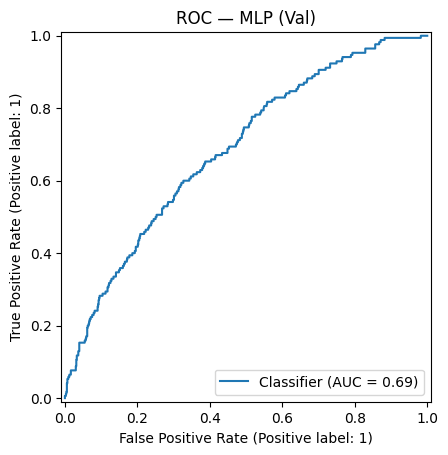

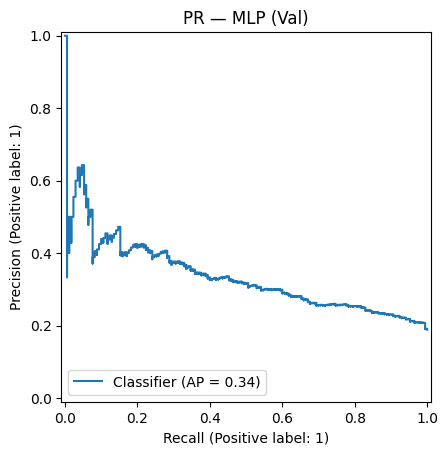

In [7]:
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(X_train_np.shape[1]).to(device)

# Class-weighted loss: positives get larger weight
pos = float(y_train_np.sum())
neg = float(len(y_train_np) - y_train_np.sum())
pos_weight = torch.tensor([neg / max(pos, 1.0)], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train_np), torch.from_numpy(y_train_np)),
    batch_size=256, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_val_np), torch.from_numpy(y_val_np)),
    batch_size=512, shuffle=False
)

best_pr = -1
best_state = None
patience = 8
bad = 0

for epoch in range(1, 51):
    model.train()
    losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    # Validation PR-AUC for early stopping
    model.eval()
    probs = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            p = torch.sigmoid(model(xb)).cpu().numpy()
            probs.append(p)
    probs = np.concatenate(probs)

    pr_auc = average_precision_score(y_val_np, probs)
    roc_auc = roc_auc_score(y_val_np, probs)
    print(f"Epoch {epoch:02d} | loss={np.mean(losses):.4f} | Val PR={pr_auc:.4f} | Val ROC={roc_auc:.4f}")

    if pr_auc > best_pr + 1e-4:
        best_pr = pr_auc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

model.load_state_dict(best_state)

# Final validation predictions
model.eval()
with torch.no_grad():
    mlp_val_proba = torch.sigmoid(model(torch.from_numpy(X_val_np).to(device))).cpu().numpy()

print("MLP ROC-AUC:", roc_auc_score(y_val_np, mlp_val_proba))
print("MLP PR-AUC: ", average_precision_score(y_val_np, mlp_val_proba))

RocCurveDisplay.from_predictions(y_val_np, mlp_val_proba)
plt.title("ROC — MLP (Val)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_val_np, mlp_val_proba)
plt.title("PR — MLP (Val)")
plt.show()


## 6) Low / Medium / High risk groups (percentile method)

Instead of picking fixed thresholds, I bucket patients by predicted probability:
- Low = bottom 70%
- Medium = 70th–90th percentile
- High = top 10%


In [8]:
def risk_bucket_by_percentile(proba, low_pct=70, high_pct=90):
    p_low = np.percentile(proba, low_pct)
    p_high = np.percentile(proba, high_pct)
    buckets = np.where(
        proba < p_low, "Low",
        np.where(proba < p_high, "Medium", "High")
    )
    return buckets, p_low, p_high

# Validation risk groups
rf_val_risk, rf_p70, rf_p90 = risk_bucket_by_percentile(rf_val_proba, 70, 90)
mlp_val_risk, mlp_p70, mlp_p90 = risk_bucket_by_percentile(mlp_val_proba, 70, 90)

print("RF thresholds: 70th =", rf_p70, " 90th =", rf_p90)
print("MLP thresholds: 70th =", mlp_p70, " 90th =", mlp_p90)

print("\nRF risk counts (Val):")
print(pd.Series(rf_val_risk).value_counts())

print("\nMLP risk counts (Val):")
print(pd.Series(mlp_val_risk).value_counts())


RF thresholds: 70th = 0.3493344302748757  90th = 0.48274055722102893
MLP thresholds: 70th = 0.5115528  90th = 0.6898787

RF risk counts (Val):
Low       630
Medium    180
High       91
Name: count, dtype: int64

MLP risk counts (Val):
Low       630
Medium    180
High       91
Name: count, dtype: int64


### Risk group event rates (Validation)
This checks if the High risk group truly has a higher event rate.


In [9]:
rf_val_df = X_val.copy()
rf_val_df["true_label"] = y_val.values
rf_val_df["pred_prob"] = rf_val_proba
rf_val_df["risk_group"] = rf_val_risk

rf_summary = rf_val_df.groupby("risk_group")["true_label"].agg(["count", "mean", "sum"]).rename(
    columns={"mean":"event_rate", "sum":"num_events"}
)
print("RF validation risk summary:")
display(rf_summary.sort_index())

mlp_val_df = X_val.copy()
mlp_val_df["true_label"] = y_val.values
mlp_val_df["pred_prob"] = mlp_val_proba
mlp_val_df["risk_group"] = mlp_val_risk

mlp_summary = mlp_val_df.groupby("risk_group")["true_label"].agg(["count", "mean", "sum"]).rename(
    columns={"mean":"event_rate", "sum":"num_events"}
)
print("MLP validation risk summary:")
display(mlp_summary.sort_index())


RF validation risk summary:


,count,event_rate,num_events
risk_group,,,
High,91,0.395604,36
Low,630,0.152381,96
Medium,180,0.211111,38


MLP validation risk summary:


,count,event_rate,num_events
risk_group,,,
High,91,0.417582,38
Low,630,0.133333,84
Medium,180,0.266667,48


## 7) Final Test Evaluation (plus risk groups)
This is the final evaluation on the test set.


In [10]:
# Random Forest test
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]
print("=== RF TEST RESULTS ===")
print("ROC-AUC:", roc_auc_score(y_test, rf_test_proba))
print("PR-AUC: ", average_precision_score(y_test, rf_test_proba))

rf_test_risk, rf_test_p70, rf_test_p90 = risk_bucket_by_percentile(rf_test_proba, 70, 90)
rf_test_df = X_test.copy()
rf_test_df["true_label"] = y_test.values
rf_test_df["pred_prob"] = rf_test_proba
rf_test_df["risk_group"] = rf_test_risk

rf_test_summary = rf_test_df.groupby("risk_group")["true_label"].agg(["count","mean","sum"]).rename(
    columns={"mean":"event_rate","sum":"num_events"}
)
print("RF test risk summary:")
display(rf_test_summary.sort_index())

# MLP test
model.eval()
with torch.no_grad():
    mlp_test_proba = torch.sigmoid(model(torch.from_numpy(X_test_np).to(device))).cpu().numpy()

print("=== MLP TEST RESULTS ===")
print("ROC-AUC:", roc_auc_score(y_test_np, mlp_test_proba))
print("PR-AUC: ", average_precision_score(y_test_np, mlp_test_proba))

mlp_test_risk, mlp_test_p70, mlp_test_p90 = risk_bucket_by_percentile(mlp_test_proba, 70, 90)
mlp_test_df = X_test.copy()
mlp_test_df["true_label"] = y_test.values
mlp_test_df["pred_prob"] = mlp_test_proba
mlp_test_df["risk_group"] = mlp_test_risk

mlp_test_summary = mlp_test_df.groupby("risk_group")["true_label"].agg(["count","mean","sum"]).rename(
    columns={"mean":"event_rate","sum":"num_events"}
)
print("MLP test risk summary:")
display(mlp_test_summary.sort_index())


=== RF TEST RESULTS ===
ROC-AUC: 0.6314020950846091
PR-AUC:  0.280017430957783
RF test risk summary:


,count,event_rate,num_events
risk_group,,,
High,90,0.355556,32
Low,630,0.150794,95
Medium,180,0.238889,43


=== MLP TEST RESULTS ===
ROC-AUC: 0.6529411764705882
PR-AUC:  0.31186176278412825
MLP test risk summary:


,count,event_rate,num_events
risk_group,,,
High,90,0.388889,35
Low,630,0.142857,90
Medium,180,0.250000,45


## 8) SHAP (Explain Random Forest predictions)

SHAP explains which features pushed the model toward higher or lower risk.
This works best for tree models like Random Forest using `TreeExplainer`.


X_val_dense shape: (901, 18)
sv_pos shape: (901, 18, 2)


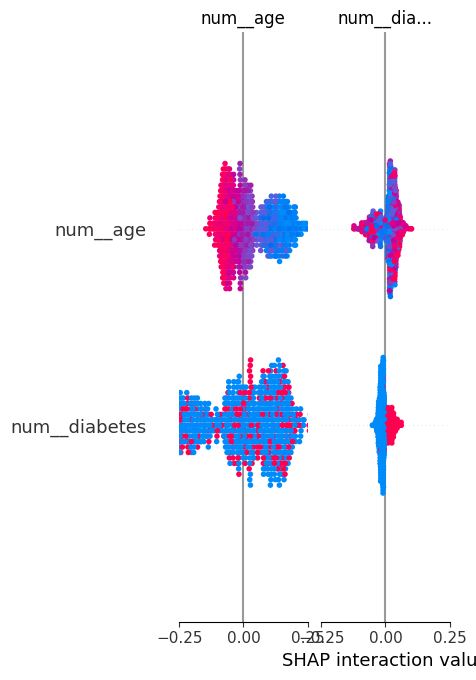

In [12]:

import shap
import numpy as np

# Pull fitted steps from the pipeline
pre = rf_model.named_steps["preprocess"]
rf  = rf_model.named_steps["rf"]

# Transform X_val using the fitted preprocessor
X_val_trans = pre.transform(X_val)

# Convert sparse -> dense (SHAP plotting is safer this way)
X_val_dense = X_val_trans.toarray() if hasattr(X_val_trans, "toarray") else np.array(X_val_trans)

# Get feature names after one-hot encoding
feature_names = pre.get_feature_names_out()

# Build explainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values
shap_values = explainer.shap_values(X_val_dense)

# --- Handle binary classification output shape safely ---
# Newer SHAP sometimes returns a list [class0, class1]
# Sometimes it returns a single array of shape (n, m)
if isinstance(shap_values, list):
    sv_pos = shap_values[1]   # positive class
else:
    sv_pos = shap_values

print("X_val_dense shape:", X_val_dense.shape)
print("sv_pos shape:", sv_pos.shape)

min_cols = min(X_val_dense.shape[1], sv_pos.shape[1])
X_val_dense = X_val_dense[:, :min_cols]
sv_pos = sv_pos[:, :min_cols]
feature_names = feature_names[:min_cols]

# Global SHAP summary plot
shap.summary_plot(sv_pos, X_val_dense, feature_names=feature_names, show=True)


### SHAP for one patient (local explanation)
This shows which features pushed the prediction up/down for one example.


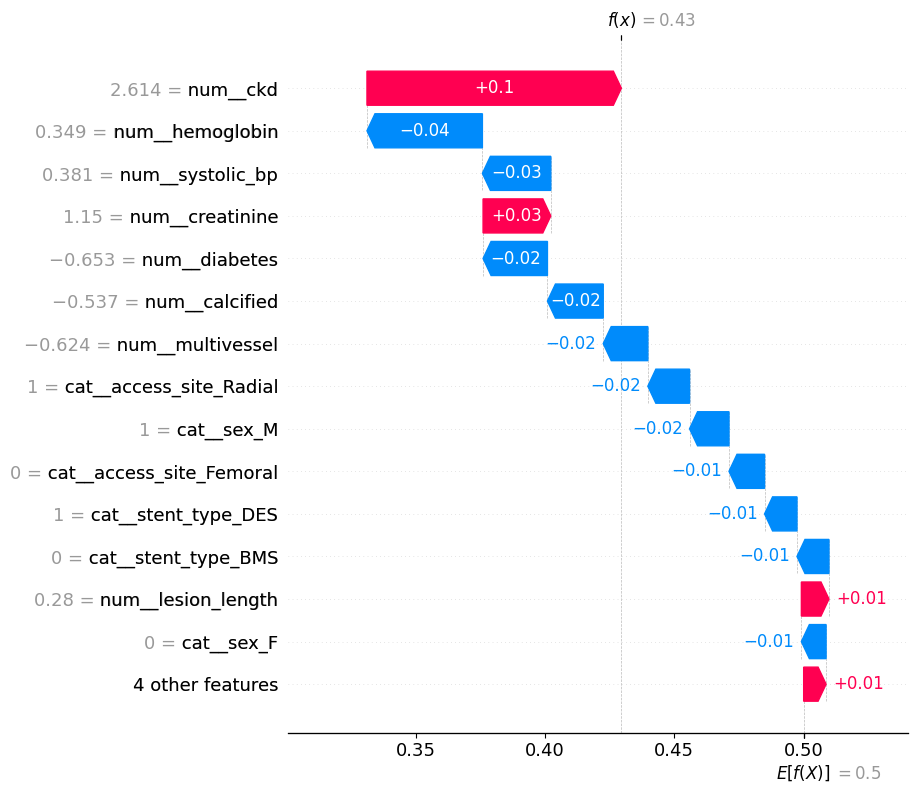

In [21]:
i = 0
sv_single = sv_pos[i, :, 1]   # pick positive class output
x_single = X_val_dense[i, :]

base = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

exp = shap.Explanation(
    values=sv_single,
    base_values=base,
    data=x_single,
    feature_names=feature_names
)

shap.plots.waterfall(exp, max_display=15)


## 9) Conclusion

In this project, I developed clinical risk prediction models to estimate adverse outcomes after coronary stent placement.

- I built two models: a **Random Forest** and a **feedforward neural network (MLP)**.
- Because adverse events were relatively rare, I addressed class imbalance using **SMOTE** for the Random Forest and **class-weighted loss** for the neural network.
- Model performance was evaluated using **ROC-AUC** and **Precision–Recall AUC (PR-AUC)**, which are appropriate for rare-event prediction.
  - On the test set, the Random Forest achieved a ROC-AUC of approximately **0.63** and a PR-AUC of **0.28**.
  - The MLP performed slightly better, with a test ROC-AUC of approximately **0.65** and a PR-AUC of **0.31**, indicating improved discrimination and precision for the positive class.
- Predicted probabilities were converted into **Low, Medium, and High risk groups** using percentile-based thresholds (bottom 70%, next 20%, top 10%).
  - These risk groups showed meaningful separation, with the **High-risk group having roughly 2–3× higher event rates** than the Low-risk group on both validation and test data.
- To improve interpretability, I used **SHAP** to analyze the Random Forest model.
  - SHAP analysis showed that clinical factors such as **chronic kidney disease, age, creatinine, and diabetes** were among the most influential predictors.
  - Local SHAP waterfall plots demonstrated how individual patient risk was increased by factors such as CKD and renal dysfunction, and reduced by protective factors such as higher hemoglobin, absence of diabetes, radial access site, and use of drug-eluting stents.

Overall, the results suggest that both models learned clinically reasonable patterns, with the MLP providing slightly stronger predictive performance and the Random Forest offering greater interpretability through SHAP-based explanations.
